# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [1]:
# import needed python libraries
# Per ora ci ho messo quanta più roba potesse servire, in seguito rimuoviamo ciò che non serve 

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import StrMethodFormatter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from art.estimators.classification import KerasClassifier

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import matplotlib.pyplot as plt
import matplotlib

from art.attacks.evasion import FastGradientMethod

# it's a library that we work with plotly
import plotly.offline as py 
import plotly.express as px
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly
import warnings # This library will be used to ignore some warnings
from collections import Counter # To do counter of some features
from plotly.subplots import  make_subplots
import numpy as np
import plotly.graph_objs as go

/home/mrnbd/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mrnbd/.local/lib/python3.10/site-packages/art/estimators/certification/__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
2024-04-30 18:58:45.960279: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 18:58:45.964372: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 18:58:4

# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

---
Begin by downloading the [German Credit Risk dataset](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data)

In [2]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)
df.head()

,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account_bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good_bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### We create a hard copy To use in the visualization part.

In [3]:
df_credit = df.copy()

### The dataset

The dataset is composed of both categorical and numerical features which are used to describe the socio-economic situation of the credit applicants, the categorical ones are codified with alpha numerical codes.As an example we report the meaning of some of the features of the dataset

**Existing Checking Account (Qualitative)**

Status of existing checking account i.e. range of money in existing checking account (if present)

| Value | Description|
| --- | --- |
| A11 | .. < 0 DM | 
| A12 | 0 <= ... < 200 DM | 
| A13 | ... >= 200 DM / salary assignments for at least 1 year |
| A14 | no checking account|

Note: DM stands for Deutsche Marks.

**Month Duration (Numerical)**

Duration in month of the asked loan

**Purpose (Qualitative)**

Purpose of the requested loan

| Value | Description|
| --- | --- |
| A40 | car (new)
| A41 | car (used)
| A42 | furniture/equipment
| A43 | radio/television
| A44 | domestic appliances
| A45 | repairs
| A46 | education
| A47 | vacation
| A48 | retraining
| A49 | business
| A410 | others

**Credit Amount (Numerical)**

Amount of money requested for the credit

**Personal Status and Sex (Qualitative)**

| Value | Description|
| --- | --- |
|A91 | male : divorced/separated
|A92 | female : divorced/separated/married
|A93 | male : single
|A94 | male : married/widowed
|A95 | female : single

**Property (Qualitative)**

Type of property owned by the applicant

| Value | Description|
| --- | --- |
|A121 | real estate
|A122 | if not A121 : building society savings agreement/ life insurance
|A123 | if not A121/A122 : car or other, not in attribute 6
|A124 | unknown / no property

**Age (Numerical)**

Age in years

**Housing (Qualitative)**

| Value | Description|
| --- | --- |
|A151 | rent
|A152 | own
|A153 | for free

**Existing credit number (Numerical)**

Number of existing credit at this bank

**Result (Response)**

| Value | Description|
| --- | --- |
|1 | good (applicant eligible for credit)
|2 | bad (applicant not eligible for credit)

As we can see the value used for describing the response are $1 \implies good$ result and $2 \implies bad$ result. 

With df.info() we can find if some data are missing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Status_account           1000 non-null   object
 1   Duration                 1000 non-null   int64 
 2   Credit_history           1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   Credit_amount            1000 non-null   int64 
 5   Savings_account_bonds    1000 non-null   object
 6   Employment_since         1000 non-null   object
 7   Install_rate             1000 non-null   int64 
 8   Personal_status_sex      1000 non-null   object
 9   debtors_guarantors       1000 non-null   object
 10  Present_residence_since  1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  Other_install_plans      1000 non-null   object
 14  Housing                  1000 non-null   

With the describe method we can see some basics statistics about the quantitative features

In [5]:
df.describe()

,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good_bad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [6]:
#Looking unique values
print(df.nunique())

Status_account               4
Duration                    33
Credit_history               5
Purpose                     10
Credit_amount              921
Savings_account_bonds        5
Employment_since             5
Install_rate                 4
Personal_status_sex          4
debtors_guarantors           3
Present_residence_since      4
Property                     4
Age                         53
Other_install_plans          3
Housing                      3
No_credits                   4
Job                          4
No_people_liable             2
Telephone                    2
foreign_worker               2
good_bad                     2
dtype: int64


Now we will now check the class distribution in the dataset to see whether there is some imbalance

In [7]:

# Positive labels
eligible= df["good_bad"] == 1
print(f"The percentage of those who are eligible for credit (good risk) is: {df[eligible].shape[0]/df.shape[0]}")

# Negative labels
not_eligible= df["good_bad"] == 2
print(f"The percentage of those who are not eligible for credit(bad risk) is: {df[not_eligible].shape[0]/df.shape[0]}")

# We can note a sligthly umbalance

The percentage of those who are eligible for credit (good risk) is: 0.7
The percentage of those who are not eligible for credit(bad risk) is: 0.3


### 1.2 Data Preprocessing ###

---
As a preprocessing step, convert categorical features to numerical features, e.g., by means of a one-hot
encoding, and apply a normalization to map all features between [0,1]. Assign labels to the dataset
indicating the true loan attribution outcomes for supervised learning. Clearly define categories or
classes representing loan approval or denial. Additionally, reserve 20% of the dataset for final testing
and assessment of the robustness of the models.

In [8]:
#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

#### Normalizing only the numerical values before one hot encoding for later uses 
scaler2 = MinMaxScaler()
df_normalized_with_categorical = df.copy()
df_normalized_with_categorical[to_remove] = scaler2.fit_transform(df_normalized_with_categorical[to_remove])
#display(df_normalized_with_categorical)

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
# display(df_encoded)

#### Setting bad to 0 and good to 1
mask_bad = df_encoded['good_bad'] == 2

df_encoded["good_bad"] = np.where(mask_bad, 0, 1)

#### Normalization between [0,1] and split into 80% training and 20% test 
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
array_df_encoded2 = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded2, columns=df_encoded.columns)

# display(df_normalized)

### From this moment on for our work we use as a  reference $1 \implies good$ and $0 \implies bad$. 

### 1.3 Exploratory Data Analysis ###
---
Delve into the dataset’s patterns using various visualization techniques, such as histograms of average
values, scatter plots of most interesting features and correlation matrices. Provide insights into under-
lying patterns and, most importantly, identify features significantly influencing loan risk classification

# **Some explorations:** <a id="Explorations"></a> <br>

- Starting by distribuition of column Age.
- Some Seaborn graphical
- Columns crossing



<h2>Let's start looking through target variable and their distribuition</h2>

In [9]:
df_credit['good_bad'] = df_credit['good_bad'].replace([1],'Good')
df_credit['good_bad'] = df_credit['good_bad'].replace([2],'Bad')
#Counts the number of Good and Bad
trace0 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]


layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

### Age

Age is a numeric column. The minimum age in the dataset is 19 and the maximum age is 75. Thus, we can visualize the distribution of age using a histogram with 56 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [10]:
df_credit.Age.describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

In [11]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   nbins=56, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

In [12]:
df_good = df_credit.loc[df_credit["good_bad"] == 'Good']['Age'].values.tolist()
df_bad = df_credit.loc[df_credit["good_bad"] == 'Bad']['Age'].values.tolist()
df_age = df_credit['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [13]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   color='good_bad', 
                   color_discrete_sequence=['blue', 'red'], 
                   title='Age Distribution for Good or Bad creditors')
fig.update_layout(bargap=0.1)
fig.show()

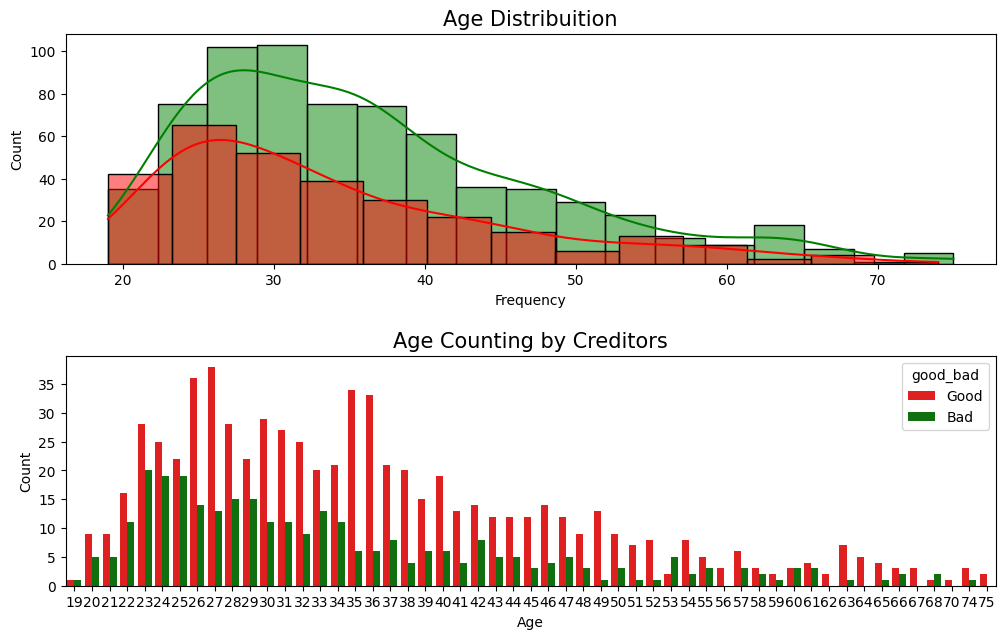

In [14]:
df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.histplot(df_good["Age"], ax=ax[0], color="g", kde=True)
g1 = sns.histplot(df_bad["Age"], ax=ax[0], color='r', kde=True)
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Frequency")


g2 = sns.countplot(x="Age",data=df_credit,
              palette=['r',"g"],  
              hue = "good_bad")
g2.set_title("Age Counting by Creditors", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

### UNIVARIATE ANALYSIS

<Axes: xlabel='Age', ylabel='Count'>

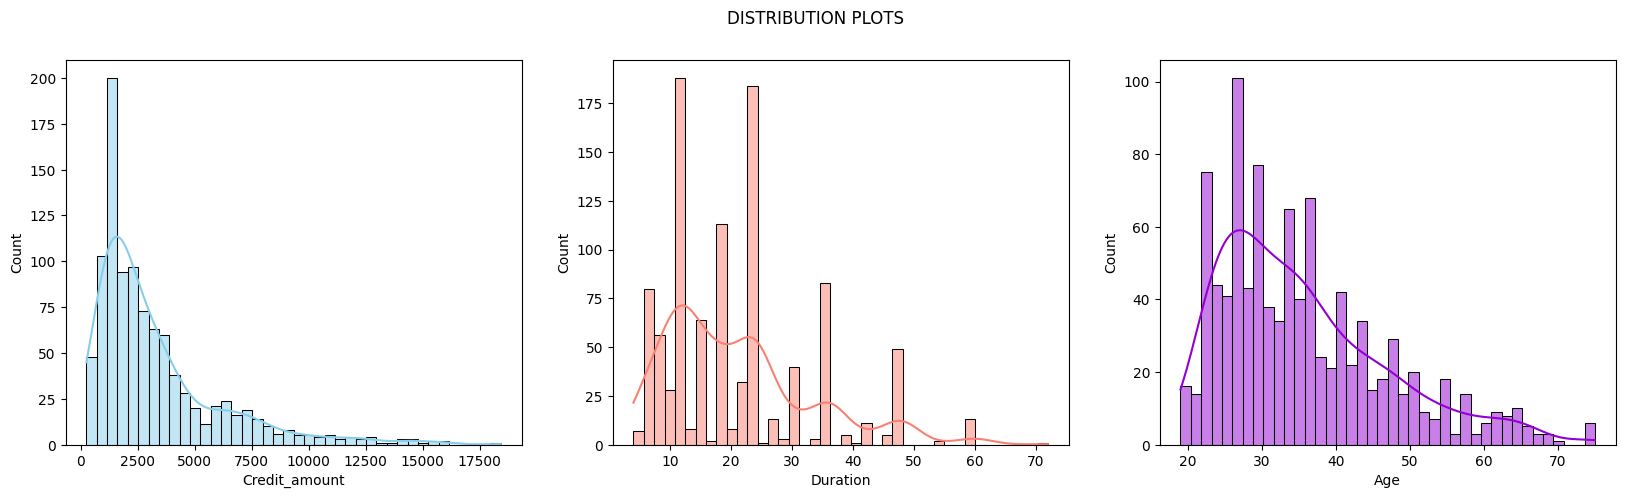

In [15]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS')
sns.histplot(df_credit['Credit_amount'], bins=40, ax=ax[0], kde=True, color='skyblue')
sns.histplot(df_credit['Duration'], bins=40, ax=ax[1], kde=True, color='salmon')
sns.histplot(df_credit['Age'], bins=40, ax=ax[2], kde=True, color='darkviolet')

### INSIGHTS
---
* Most of the credit cards have an amount of 1500 - 4000
* The Credit amount is positively skewed, So the samples are dispersed

In [16]:
#Show basic stats
df_credit[['Age', 'Duration', 'Credit_amount']].describe()

,Age,Duration,Credit_amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


### BIVARIATE ANALYSIS

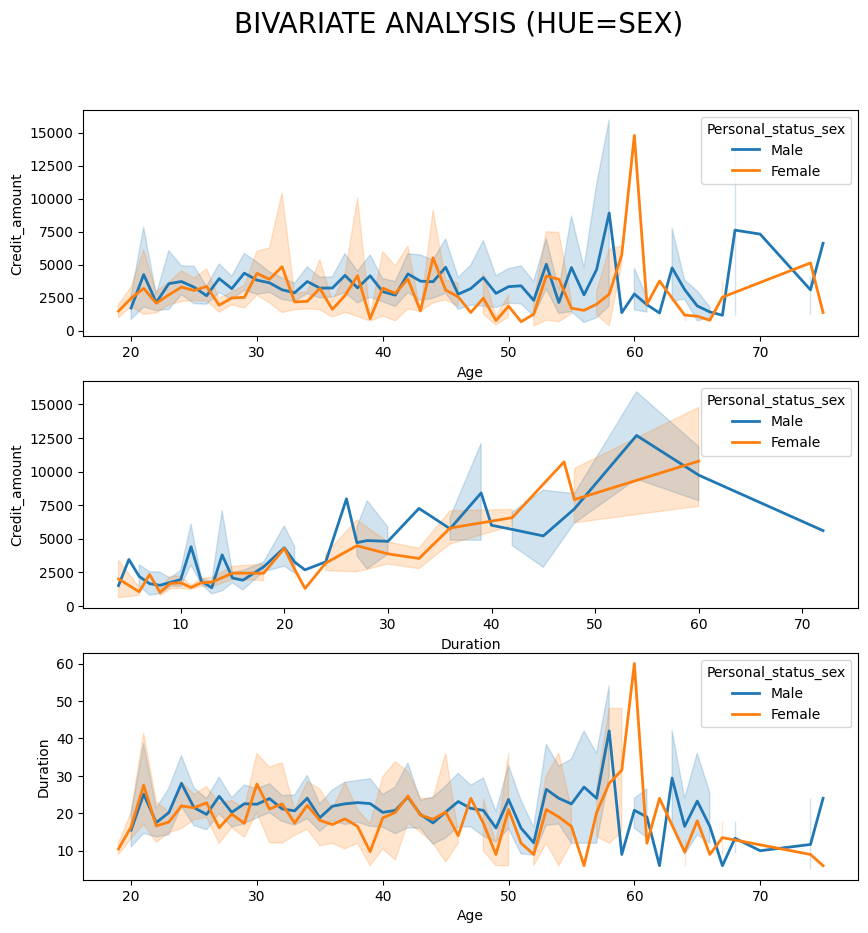

In [17]:
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A91'],'Male') #A91 : male   : divorced/separated
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A94'],'Male') #A94 : male   : married/widowed
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A93'],'Male') #A93 : male   : single
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A92'],'Female') #A92 : female : divorced/separated/married
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A95'],'Female') #A95 : female : single
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=SEX)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[0]);
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[1]);
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='Personal_status_sex', lw=2, ax=ax[2]);


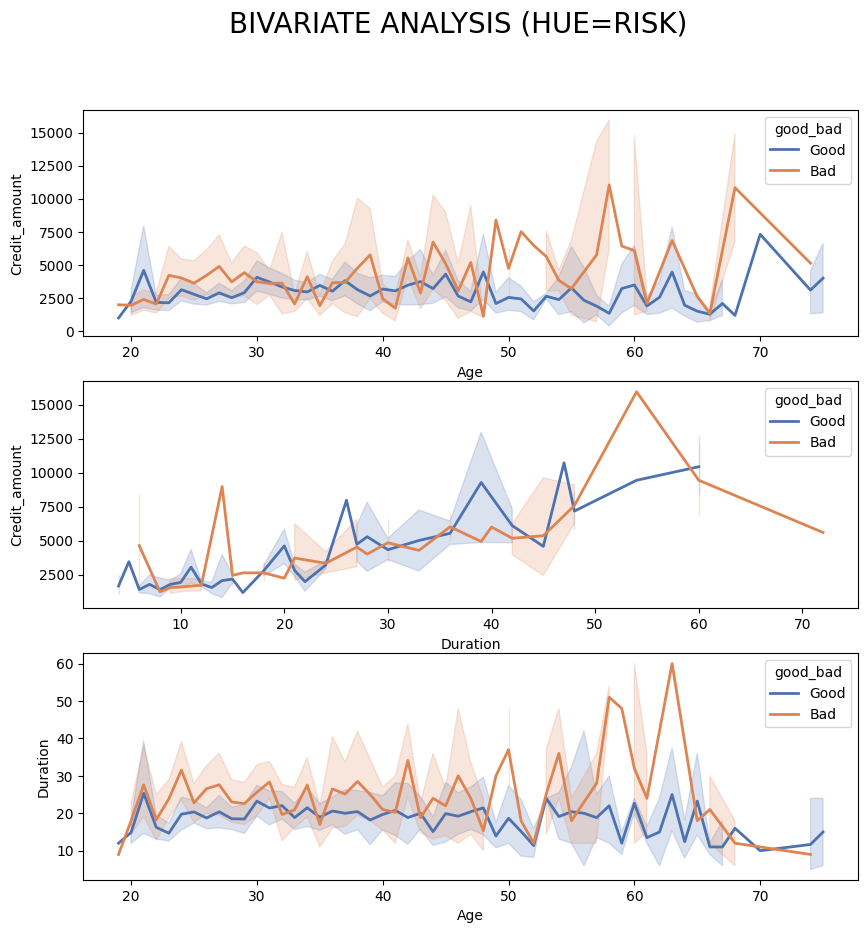

In [18]:
ig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=RISK)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='good_bad', lw=2, ax=ax[0], palette='deep');
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='good_bad', lw=2, ax=ax[1], palette='deep');
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='good_bad', lw=2, ax=ax[2], palette='deep');

### INSIGHTS
---
* There is a linear relationship between Duration and Creadit Amount, Which makes sense because usually, people take bigger credits for longer periods. 
* The trend Between Age and Credit amount is not clear.

### PAIRPLOT TO VISUALIZE FEATURES WITH LINEAR RELATIONSHIP

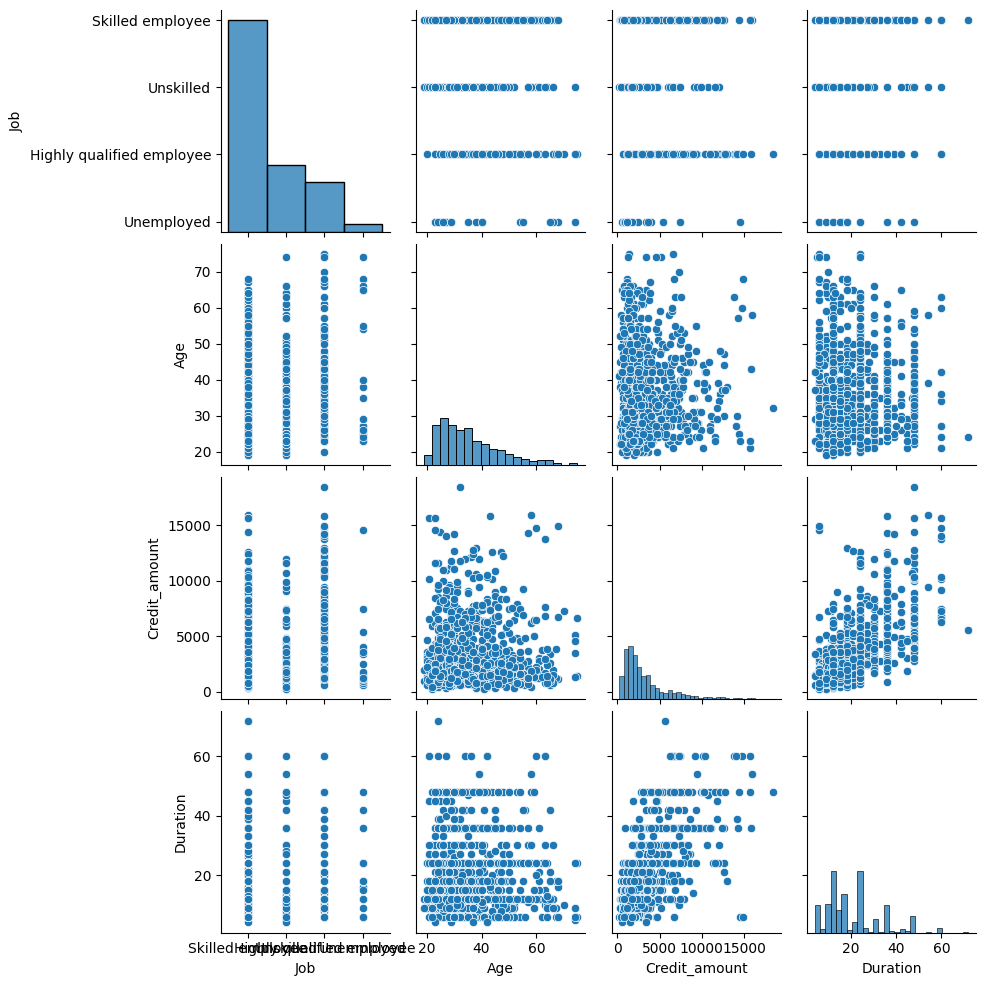

In [19]:
df_credit['Job'] = df_credit['Job'].replace(['A171'],'Unemployed')
df_credit['Job'] = df_credit['Job'].replace(['A172'],'Unskilled')
df_credit['Job'] = df_credit['Job'].replace(['A173'],'Skilled employee')
df_credit['Job'] = df_credit['Job'].replace(['A174'],'Highly qualified employee')
sns.pairplot(df_credit, vars=['Job','Age','Credit_amount','Duration']);

# A171 : unemployed/ unskilled  - non-resident
# A172 : unskilled - resident
# A173 : skilled employee / official
# A174 : management/ self-employed/highly qualified employee/ officer



######################################################
#Use only credit_amount relationships 


In [20]:
fig = px.scatter(df_credit, 
                 x='Credit_amount', 
                 y='Duration', 
                 color='good_bad', 
                 opacity=0.8, 
                 hover_data=['Personal_status_sex','Age'], 
                 title='Duration vs. Credit amount')
fig.update_traces(marker_size=5)
fig.show()

#### PROVARE A FARE L'EFFETTO DI AGGIUNGERE RUMORE PER MARCARE ANCORA DI PIU' L'ANDAMENTO 
### TRy to add Jitter

### **We tried to emphasize this correlation by adding noise according to the jitter technique**

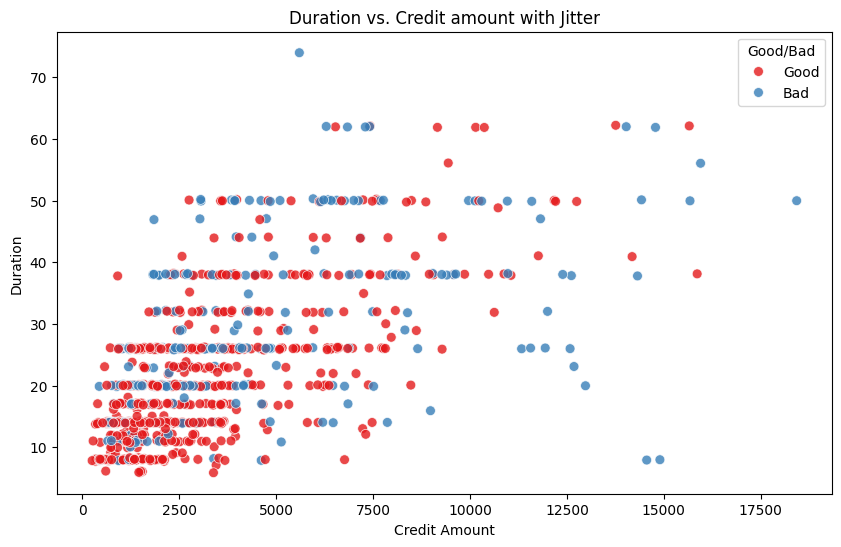

In [21]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.8, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Additional customization
plt.title('Duration vs. Credit amount with Jitter')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()




### **We have inserted an effect to accentuate the points of greatest density**

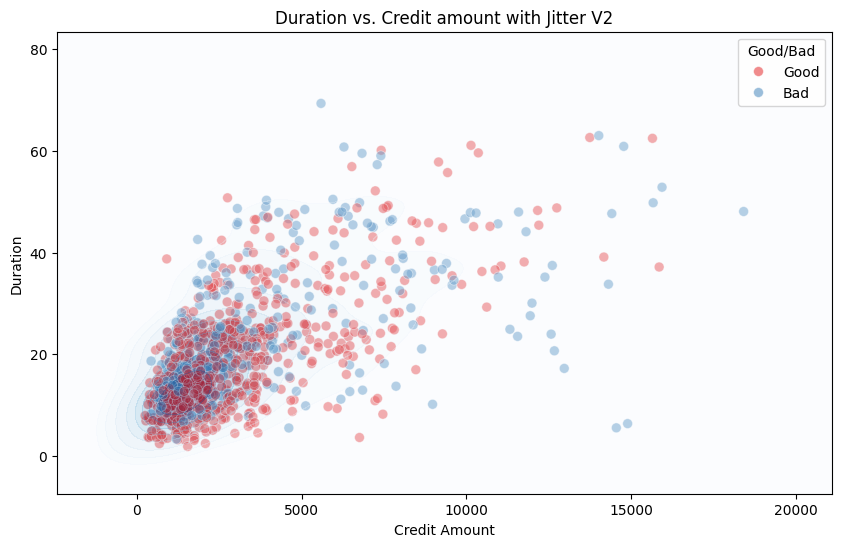

In [22]:
def jitter(values, j):
    return values + np.random.normal(0, j, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.5, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Calculate point density
sns.kdeplot(data=df_credit, x='Credit_amount', y='Duration', cmap="Blues", fill=True, thresh=False, alpha=0.3)

# Additional customization
plt.title('Duration vs. Credit amount with Jitter V2')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()



### Credit Amount
---
The next 4 plots are a different visualizzation of the Credit_Amount visualization

#### Credit_Amount - Count

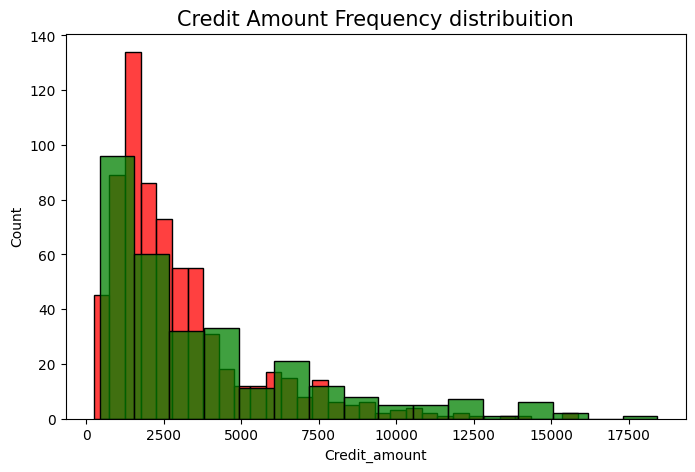

In [23]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.histplot(df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"], color='r')
g = sns.histplot(df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

##### I woul considera a gaussian distribution for plotting Credit_Amount and Count

#### Credit_Amount - Job

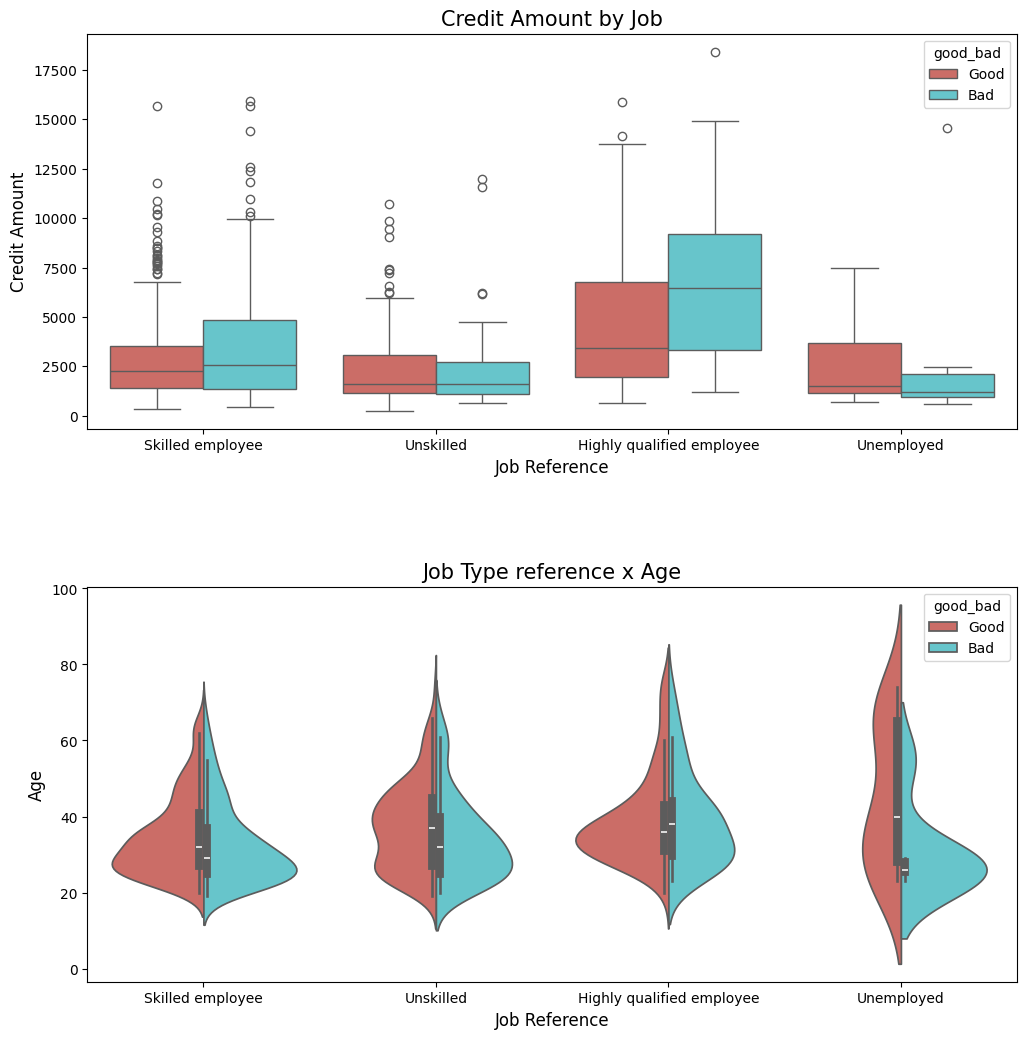

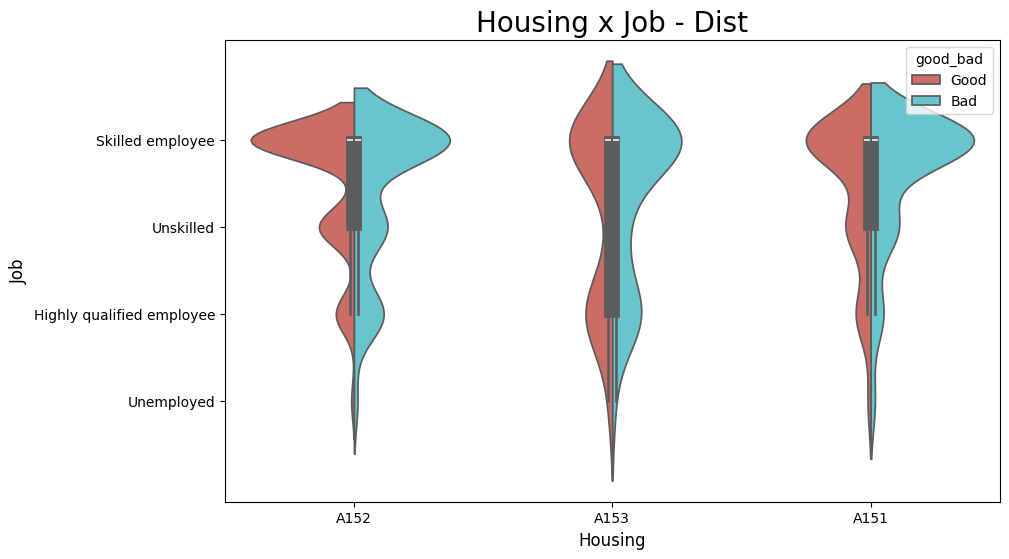

In [24]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

g1 = sns.boxplot(x="Job", y="Credit_amount", data=df_credit, 
            palette="hls", ax=ax[0], hue="good_bad")
g1.set_title("Credit Amount by Job", fontsize=15)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="Job", y="Age", data=df_credit, ax=ax[1],  
               hue="good_bad", split=True, palette="hls")
g2.set_title("Job Type reference x Age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

###############################################################################################################################################
#Credit Amount by Job (da tenere solo per la relazione perchè è molto chiara)
#Job type reference x Age (da togliere)

trace0 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)

trace1 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

######################################################################################################################################################
# Da utilizzare per fare eventuali considerazioni numeriche, anche se non ne sono troppo sicuro

plt.figure(figsize = (10,6))

g = sns.violinplot(x="Housing",y="Job",data=df_credit,
                   hue="good_bad", palette="hls",split=True)
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Job", fontsize=12)
g.set_title("Housing x Job - Dist", fontsize=20)

plt.show()

##################################################################################################################################################


#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

<h2>Creating a categorical variable to handle with the Age variable </h2>

In [25]:
#Let's look the Credit Amount column
interval = (19, 25, 35, 50, 70)

cats = ['Senior (35-50)', 'Adult (25-35)', 'Young (19-25)', 'Student (0-19)']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats) #age_categories


df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

###################################################################################################################


trace0 = go.Box(
    y=df_good["Credit_amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit_amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

# Credit Amount - Housing

<h2>I will now Look the distribuition of Housing own and rent by Risk</h2>


In [26]:
df_credit['Housing'] = df_credit['Housing'].replace(['A151'],'rent')
df_credit['Housing'] = df_credit['Housing'].replace(['A152'],'own')
df_credit['Housing'] = df_credit['Housing'].replace(['A153'],'free')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

##################################################################################################################################################
# Maybe we can create a section in which we briefly examinate all the aspect, but in general i don't think this is useful





trace0 = go.Box(
    y=df_credit["Credit_amount"],
    x=df_credit["Housing"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit['Credit_amount'],
    x=df_credit['Housing'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Distribuition of Credit Amount by Housing'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

#### Credit Amount - Sex

In [27]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

#### Credit Amount - Foreign worker

In [28]:
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A201'],'foreign worker')
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A202'],'None foreign worker')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Foreign worker comparison', 'Credit Amount by foreign worker'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Foreign worker Distribuition', boxmode='group')
py.iplot(fig, filename='Foreign_worker-subplot')

In [29]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Status_account           1000 non-null   object  
 1   Duration                 1000 non-null   int64   
 2   Credit_history           1000 non-null   object  
 3   Purpose                  1000 non-null   object  
 4   Credit_amount            1000 non-null   int64   
 5   Savings_account_bonds    1000 non-null   object  
 6   Employment_since         1000 non-null   object  
 7   Install_rate             1000 non-null   int64   
 8   Personal_status_sex      1000 non-null   object  
 9   debtors_guarantors       1000 non-null   object  
 10  Present_residence_since  1000 non-null   int64   
 11  Property                 1000 non-null   object  
 12  Age                      1000 non-null   int64   
 13  Other_install_plans      1000 non-null   object  
 14  Housing  

### Credit Amount - Saving Accounts

Description of Distribuition Saving accounts by Risk:  
good_bad               Bad  Good
Savings_account_bonds           
Bad                    217   386
Excellent                6    42
Good                    11    52
Middle                  34    69
No saving account       32   151


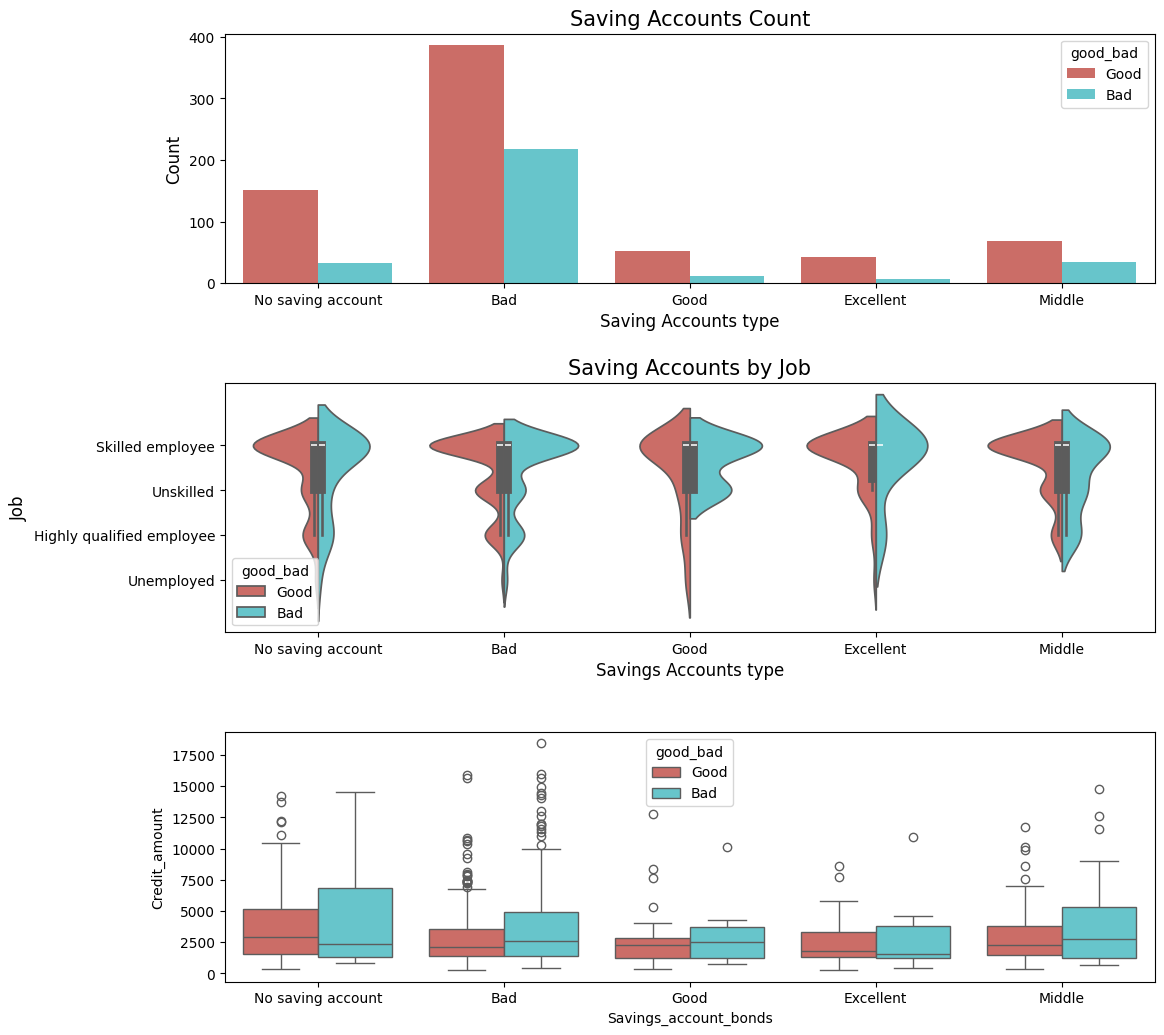

In [30]:
#Attibute 6:  (qualitative)
#	      Savings account/bonds
#	      A61 :          ... <  100 DM Bad
#	      A62 :   100 <= ... <  500 DM Middle
#	      A63 :   500 <= ... < 1000 DM Good
#	      A64 :          .. >= 1000 DM Excellent
#              A65 :   unknown/ no savings account
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A61'],'Bad')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A62'],'Middle')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A63'],'Good')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A64'],'Excellent')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A65'],'No saving account')

count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')


######################################################################################################################################################
#Also here, i would consider "Credit Amount by Savings Acc" but the others i don't think they're interesting

print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df_credit["Savings_account_bonds"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Savings_account_bonds", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Savings_account_bonds", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Savings_account_bonds", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


########################################################################
# The last image is exactly the same as the last previouse one "Credit Account by saving account", so as before
# Quella con cui si può interagire (che restituire min, max, mean, ecc...) la possiamo usare per fare delle considerazioni nella relazione.
# Mentre quella quì in basso la possiamo usare per visualizzare meglio gli outliers



### Credit Amount - Status Accounts

Description of Distribuition Status accounts by Risk:  
good_bad        Bad  Good
Status_account           
In Debt         135   139
Normal          105   164
Rich             14    49
Uknown           46   348


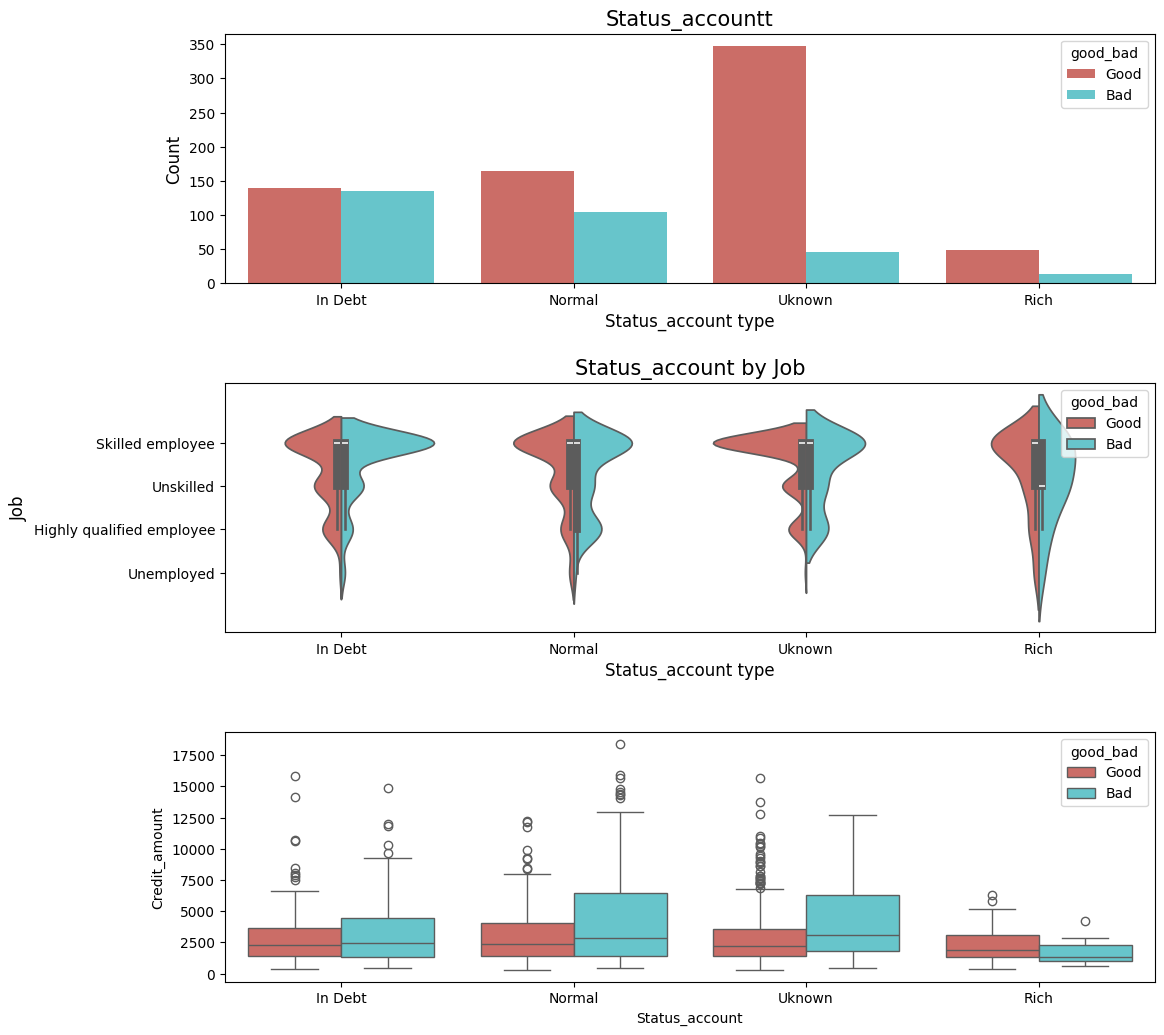

In [31]:
#Attribute 1:  (qualitative)
#	       Status of existing checking account
#               A11 :      ... <    0 DM
#	       A12 : 0 <= ... <  200 DM
#	       A13 :      ... >= 200 DM /
#		     salary assignments for at least 1 year
#               A14 : no checking account

df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Normal')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'Uknown')


count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Status_account','Credit Amount by Status_account', 
                                          'Age by Status_account'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Status_account Exploration', boxmode='group')

py.iplot(fig, filename='combined-statusAccount')

print("Description of Distribuition Status accounts by Risk:  ")
print(pd.crosstab(df_credit["Status_account"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Status_account", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Status_accountt", fontsize=15)
g.set_xlabel("Status_account type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Status_account", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Status_account by Job", fontsize=15)
g1.set_xlabel("Status_account type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Status_account", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Status Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Status Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


### Credit_Amount - Purpose

Values describe: 
good_bad             Bad  Good
Purpose                       
Business              34    63
Domestic appliances    4     8
Education             22    28
Furniture/equipment   58   123
New Car               89   145
Others                 5     7
Radio/television      62   218
Repairs                8    14
Retraining             1     8
Used Car              17    86


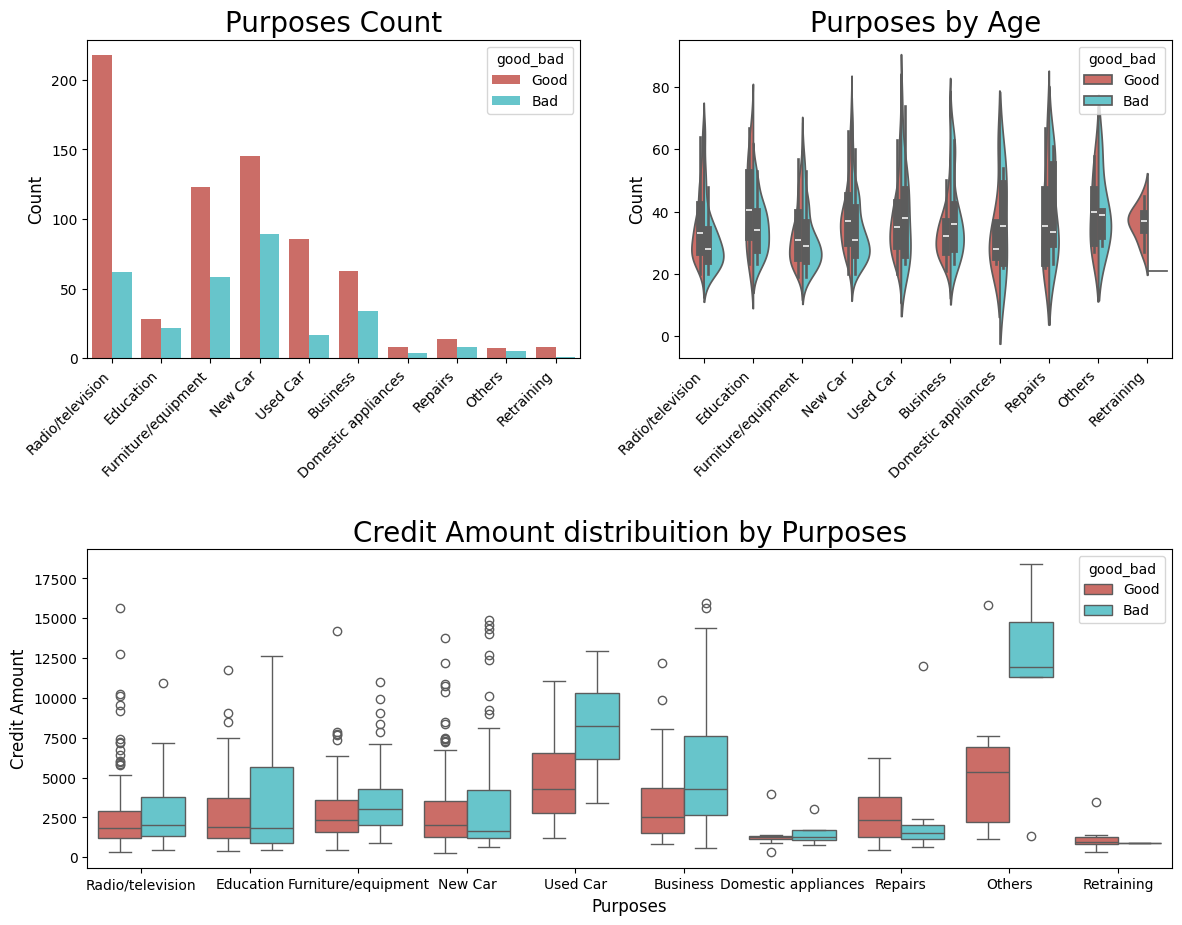

In [32]:
## Gianluca : Alberto vedi se toglierlo 
## Alberto : NO!!
df_credit['Purpose'] = df_credit['Purpose'].replace(['A40'],'New Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A41'],'Used Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A42'],'Furniture/equipment')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A43'],'Radio/television')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A44'],'Domestic appliances')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A45'],'Repairs')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A46'],'Education')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A47'],'Vacation')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A48'],'Retraining')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A49'],'Business')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A410'],'Others')
print("Values describe: ")
print(pd.crosstab(df_credit.Purpose, df_credit.good_bad))

plt.figure(figsize = (14,12))


plt.subplot(221)
g = sns.countplot(x="Purpose", data=df_credit, 
              palette="hls", hue = "good_bad")
g.set_xticks(g.get_xticks())
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df_credit, 
                    palette="hls", hue = "good_bad",split=True)
g1.set_xticks(g1.get_xticks())
g1.set_xticklabels(g1.get_xticklabels(),rotation=45, ha="right")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit_amount", data=df_credit, 
               palette="hls", hue = "good_bad")
g2.set_xticks(g2.get_xticks())
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

### Credit_Amount - Duration

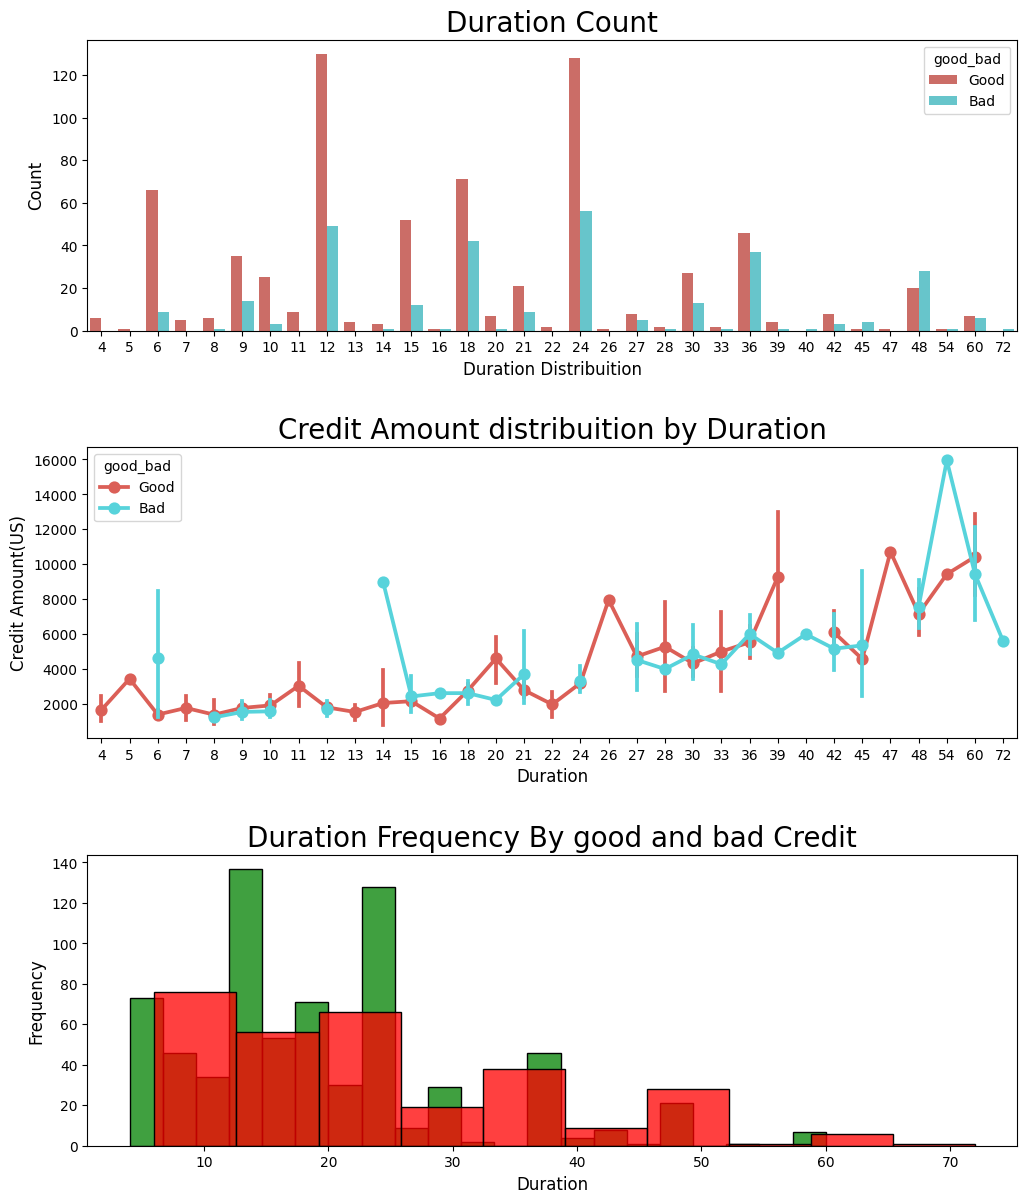

In [33]:
plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df_credit, 
              palette="hls",  hue = "good_bad")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit_amount",data=df_credit,
                   hue="good_bad", palette="hls")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.histplot(df_good["Duration"], color='g')
g2 = sns.histplot(df_bad["Duration"], color='r')
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency By good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()

<h2> Checking/Status Account variable </h2>

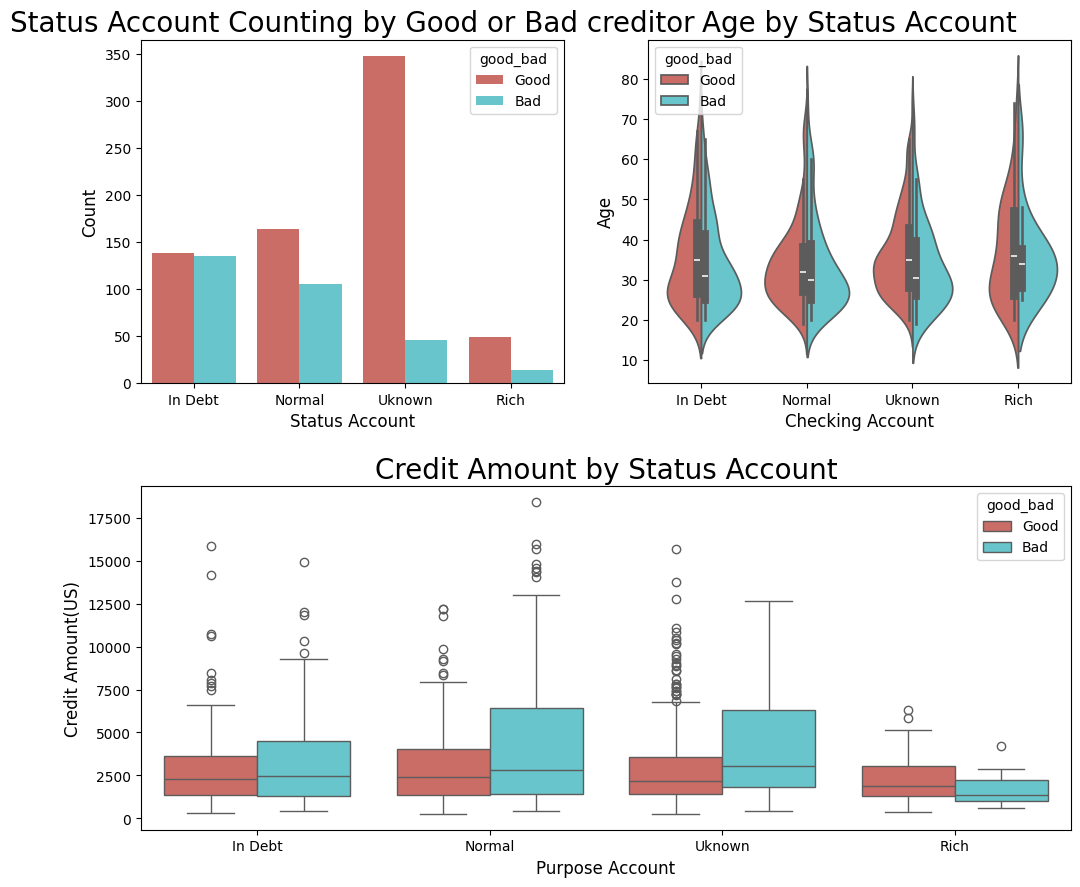

In [34]:
df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Moderate')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'No checking')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Status accounts Distribuition',
    xaxis=dict(title='Status accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

trace0 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Good']["Credit_amount"],
    x=df_credit[df_credit["good_bad"] == 'Good']["Status_account"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Bad']['Credit_amount'],
    x=df_credit[df_credit["good_bad"] == 'Bad']['Status_account'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Status distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

##################################################
plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Status_account", data=df_credit, 
              palette="hls", hue="good_bad")
g.set_xlabel("Status Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Status Account Counting by Good or Bad creditor", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Status_account", y="Age", data=df_credit, palette="hls", hue = "good_bad",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Status Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Status_account",y="Credit_amount", data=df_credit,hue='good_bad',palette="hls")
g2.set_xlabel("Purpose Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Status Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()

In [35]:
print(pd.crosstab(df_credit.Personal_status_sex, df_credit.Job))

Job                  Highly qualified employee  Skilled employee  Unemployed  \
Personal_status_sex                                                            
Female                                      37               197          12   
Male                                       111               433          10   

Job                  Unskilled  
Personal_status_sex             
Female                      64  
Male                       136  


In [36]:
print(pd.crosstab(df_credit["Status_account"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Status_account                   
In Debt                  88   186
Normal                   86   183
Rich                     20    43
Uknown                  116   278


In [37]:
print(pd.crosstab(df_credit["Purpose"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Purpose                          
Business                 19    78
Domestic appliances       6     6
Education                21    29
Furniture/equipment      74   107
New Car                  70   164
Others                    3     9
Radio/television         85   195
Repairs                   5    17
Retraining                3     6
Used Car                 24    79


## **Remember the result of data preprocessing is df_normalized**